**The Association Between Heart Disease and Age, Maximum Heart Rate, and Resting Blood Pressure**

**Introduction**

Everyone in today's hectic society faces pressure from a variety of sources, such as employment, education, housing, health, and so forth. Individuals in this continuously stressful setting experience a wide range of health issues. According to medical professionals, heart disease, also known as cardiovascular disease, is the main cause of mortality. Heart-related diseases account for almost 31% of deaths globally, according to data released by the World Health Organization (WHO).

The heart, one of the most vital organs in the human body, continuously and regularly pumps blood to the rest of the body to maintain normal physiological activity. Its functions include carrying oxygen, nutrients, and certain metabolites. The topic of how to track cardiac health and estimate the chance of illness has attracted a lot of attention. In order to determine the likelihood of heart disease, this article focuses on the potential predictive value of age, maximum heart rate, and resting blood pressure at admission.

In the Heart Disease dataset donated to the University of California, Irvine, a group of researchers used 14 variables to determine whether or not a patient would be diagnosed with heart disease. Using the combined data from scientists in Cleveland, Hungary, Long Island, and Switzerland as a training set for our K-nearest prediction, the given dataset will be narrowed down to answer the project-specific question. )

**Preliminary Exploratory Data Analysis**

In [42]:
#Packages
library(repr)
library(tidyverse)
library(tidymodels)
library(ggplot2)
options(repr.matrix.max.rows = 10)

In [44]:
# Variables (Column names according to the dataset specification)
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                  "thalach", "exang", "oldpeak", "slope", "ca", "thal", "is_disease_present")

#Datasets of Heart Disease from each country
cleveland <- read_csv("https://raw.githubusercontent.com/holiday-sean/dsci100_project/main/heart_and_disease/processed.cleveland.data", 
                                    col_names = column_names) 
hungarian <- read_csv("https://raw.githubusercontent.com/holiday-sean/dsci100_project/main/heart_and_disease/processed.hungarian.data", 
                                    col_names = column_names)
switzerland <- read_csv("https://raw.githubusercontent.com/holiday-sean/dsci100_project/main/heart_and_disease/processed.switzerland.data",
                                    col_names = column_names)
va <- read_csv("https://raw.githubusercontent.com/holiday-sean/dsci100_project/main/heart_and_disease/processed.va.data", 
                                    col_names = column_names)

#Dataset of Heart Disease (Combines the datasets from each country into one dataset)
heart_disease_all <- rbind(cleveland, hungarian) |>
    rbind(switzerland) |>
    rbind(va)

#Removing the NA variable & setting the 'is_disease_present' as the factor variable
heart_disease_all[heart_disease_all == "?"] <- NA

heart_disease_all_final <- heart_disease_all |>
    select(age, thalach, is_disease_present) |>
    na.omit(heart_disease_all) |>
    mutate(is_disease_present = as.character(is_disease_present)) |>
    mutate(is_disease_present = as_factor(is_disease_present)) |>
    mutate(is_disease_present = fct_recode(is_disease_present, "No" = "0", "Yes" = "1", "Yes" = "2", "Yes" = "3", "Yes" = "4"))

# heart_disease_all_final <- heart_disease_all |>
    # mutate(is_disease_present = as.character(is_disease_present)) |>
    # mutate(is_disease_present = as_factor(is_disease_present)) |>
    # mutate(is_disease_present = fct_recode(is_disease_present, "No" = "0", "Yes" = "1", "Yes" = "2", "Yes" = "3", "Yes" = "4"))

# Converting data into numerical values
heart_disease_converted <- type.convert(heart_disease_all_final, na.strings = "NA", as.is = FALSE, dec = ".", 
            numerals = c("allow.loss")) 

heart_disease_converted

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thal
dbl (5): age, sex, cp, oldpeak, is_disease_present

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal
dbl (5): age, sex, cp, chol, is_disease_p

age,thalach,is_disease_present
<int>,<int>,<fct>
63,150,No
67,108,Yes
67,129,Yes
37,187,No
41,172,No
⋮,⋮,⋮
62,138,Yes
46,126,Yes
54,154,Yes


In [45]:
heart_disease_converted |> 
    map_df(~sum(is.na(.x)))

age,thalach,is_disease_present
<int>,<int>,<int>
0,0,0


In [46]:
heart_disease_converted |>
    select(-thalach, -age) |>
    na.omit() |>
    nrow()

[1] 865

In [47]:
heart_disease_split <- initial_split(heart_disease_converted, prop = 0.75, strata = is_disease_present)
heart_disease_training <- training(heart_disease_split)
heart_disease_training
heart_disease_testing <- testing(heart_disease_split) 

age,thalach,is_disease_present
<int>,<int>,<fct>
63,150,No
37,187,No
41,172,No
56,178,No
57,163,No
⋮,⋮,⋮
53,128,Yes
62,138,Yes
46,126,Yes


In [50]:
#Summarizing (Exploratory Analysis)

#Shows the number of observations from the two classes
summarized_count_classes <- heart_disease_training |>
    summarize(count_disease_present = sum(is_disease_present == "Yes", na.rm = TRUE),
              count_disease_not_present = sum(is_disease_present == "No", na.rm = TRUE))

colnames(summarized_count_classes) <- c("# Observations with heart disease", "# Observations without heart disease")
summarized_count_classes

#Shows the mean/average of each variable we have chosen to use as a predictor
summarized_vars <- heart_disease_converted |> 
    group_by(is_disease_present) |>
    summarize(avg_age = mean(age, na.rm = TRUE),
             avg_maximum_heart_rate_achieved = mean(thalach, na.rm = TRUE))

colnames(summarized_vars) <- c("Heart disease present?", "Avg age", "Avg max heart rate achieved")
summarized_vars

# Observations with heart disease,# Observations without heart disease
<int>,<int>
355,293


Heart disease present?,Avg age,Avg max heart rate achieved
<fct>,<dbl>,<dbl>
No,50.20205,148.8005
Yes,55.55485,128.2616


**Summarizing (Exploratory Analysis) Explanation**

The summary table is used to show the number of observations recorded for the two classes (heart disease is present vs. heart disease is not present) and presents the summarized data in the form of a tibble. Summary statistics are important to the analysis of the data because they show the generalized distribution of the data with respect to the variables we are using as predictors. For example, the “Avg max heart rate achieved” column provides the average of all the maximum achieved blood pressures for people with and without heart disease. From these statistics, we observe that people with heart disease generally have a lower maximum heart rate achieved, which suggests that it is a good predictor for heart disease. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


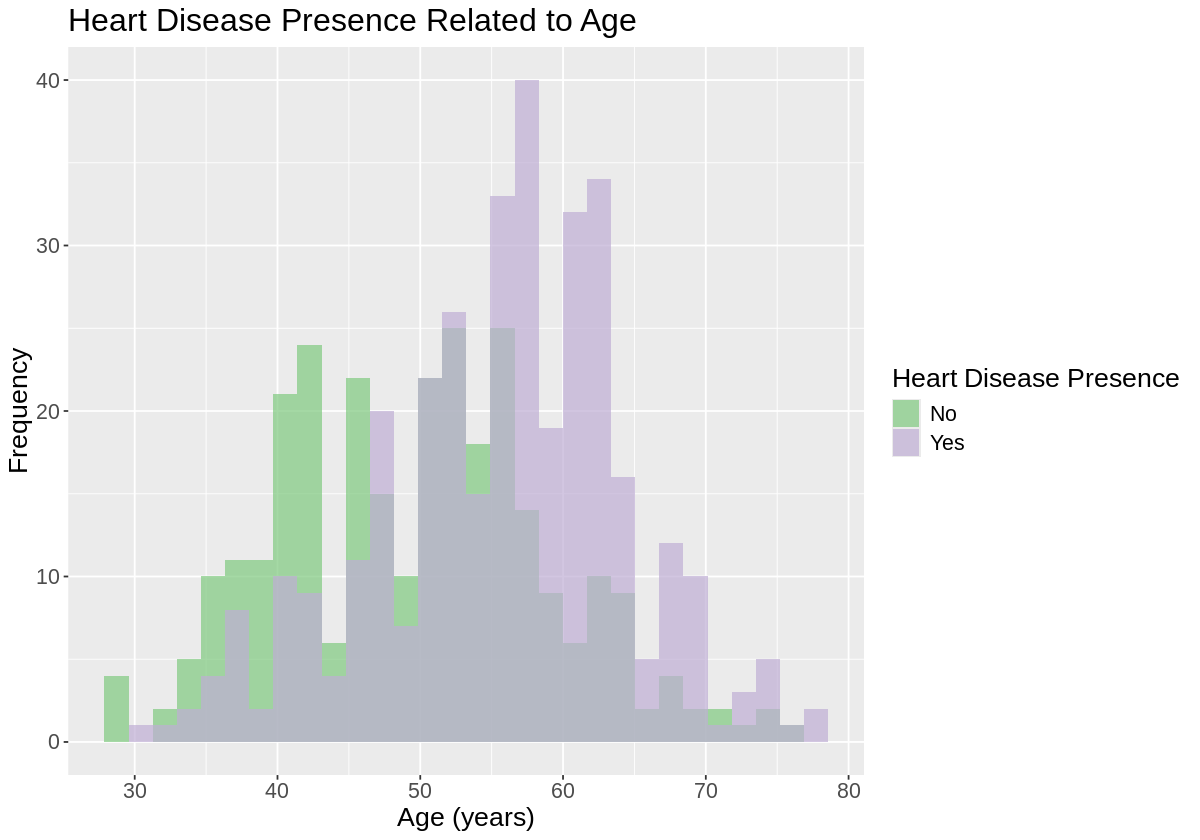

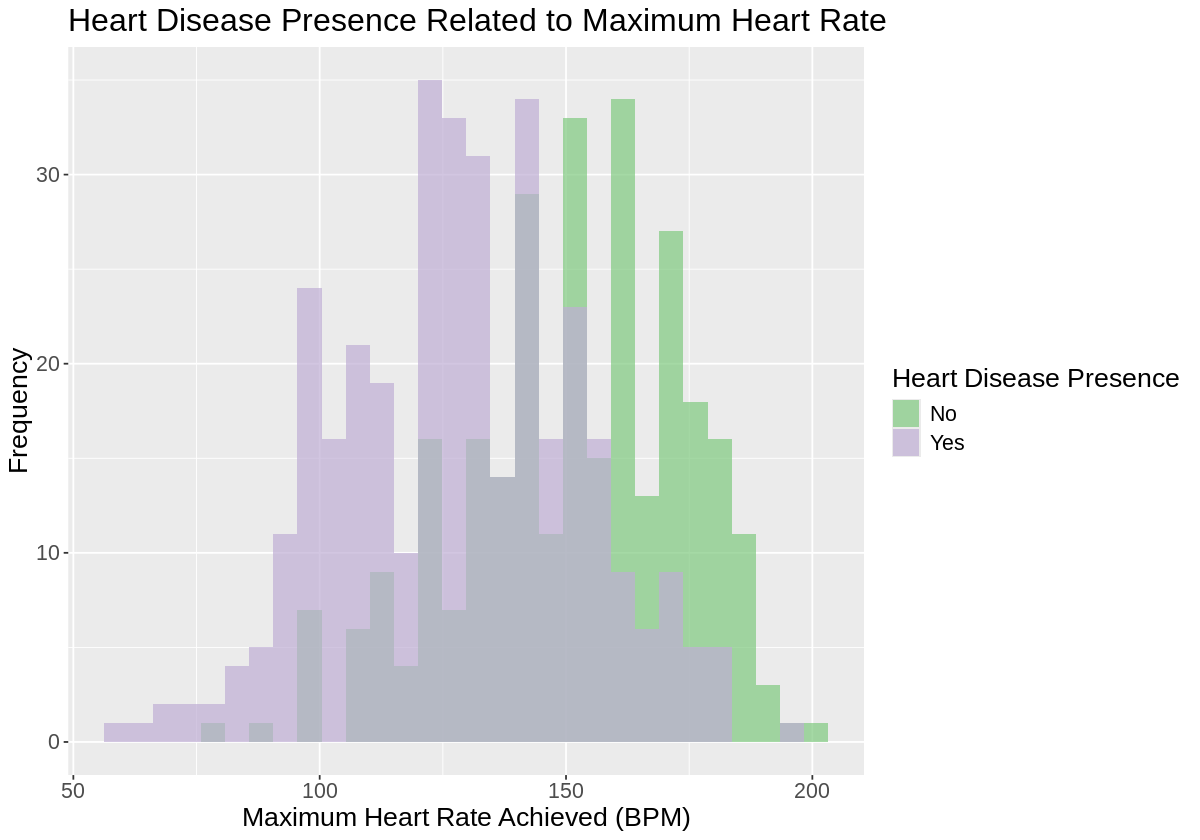

In [51]:
#Data Visualization (Exploratory Analysis)

#Quantitative Variables Used (age, trestbps, thalach)
options(repr.plot.width = 10, repr.plot.height = 7)

#Distribution of Age related to Heart Disease
age_histogram <- heart_disease_training %>%
  ggplot(aes(x = age, fill = is_disease_present)) + 
  geom_histogram(alpha = 0.7,               
                 position = "identity") +  
  labs(x = "Age (years)",
       y = "Frequency",
       title = "Heart Disease Presence Related to Age",
       fill = "Heart Disease Presence") +
  scale_fill_brewer(palette = 'Accent') +
  theme(text = element_text(size = 16))

age_histogram

#Distribution of Resting Blood Pressure (trestbps) related to Heart Disease
# trestbps_histogram <- heart_disease_training %>%
#  ggplot(aes(x = trestbps, fill = is_disease_present)) + 
#  geom_histogram(alpha = 0.7,               
#                 position = "identity") +  
#  labs(x = "Resting Blood Pressure (on admission to the hospital) (mmHg)",
#       y = "Frequency",
#       title = "Heart Disease Presence Related to Resting Blood Pressure",
#       fill = "Heart Disease Presence") +
#  scale_fill_brewer(palette = 'Accent') +
#  theme(text = element_text(size = 16))

# trestbps_histogram

#Distribution of Maximum Heart Rate Achieved (thalach) related to Heart Disease
thalach_histogram <- heart_disease_training %>%
  ggplot(aes(x = thalach, fill = is_disease_present)) +  
  geom_histogram(alpha = 0.7,               
                 position = "identity") +  
  labs(x = "Maximum Heart Rate Achieved (BPM)",
       y = "Frequency",
       title = "Heart Disease Presence Related to Maximum Heart Rate",
       fill = "Heart Disease Presence") +
  scale_fill_brewer(palette = 'Accent') +
  theme(text = element_text(size = 16))

thalach_histogram

**Methods**

We will conduct our data analysis using three variables from the Heart Disease dataset to predict whether or not an unknown patient has heart disease. As predictors, we are using age, resting blood pressure, and maximum heart rate achieved. The given data is a training set for our K-nearest neighbor prediction and the responding variable, whether or not a patient has heart disease, will be predicted. 

To visualize the results, a combination of tables and scatterplots will be used. The table will contain summaries of the data and are an easy way to visualize the results of the prediction. The scatterplots will visualize the results and predictions made by the K-nearest neighbor for unknown patients. 

**Results**

[1] 46

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6589862


.pred_class,age,thalach,is_disease_present
<fct>,<int>,<int>,<fct>
Yes,67,129,Yes
Yes,62,160,Yes
Yes,56,142,Yes
No,44,173,No
No,54,160,No
⋮,⋮,⋮,⋮
Yes,58,110,No
Yes,60,140,Yes
Yes,57,96,No


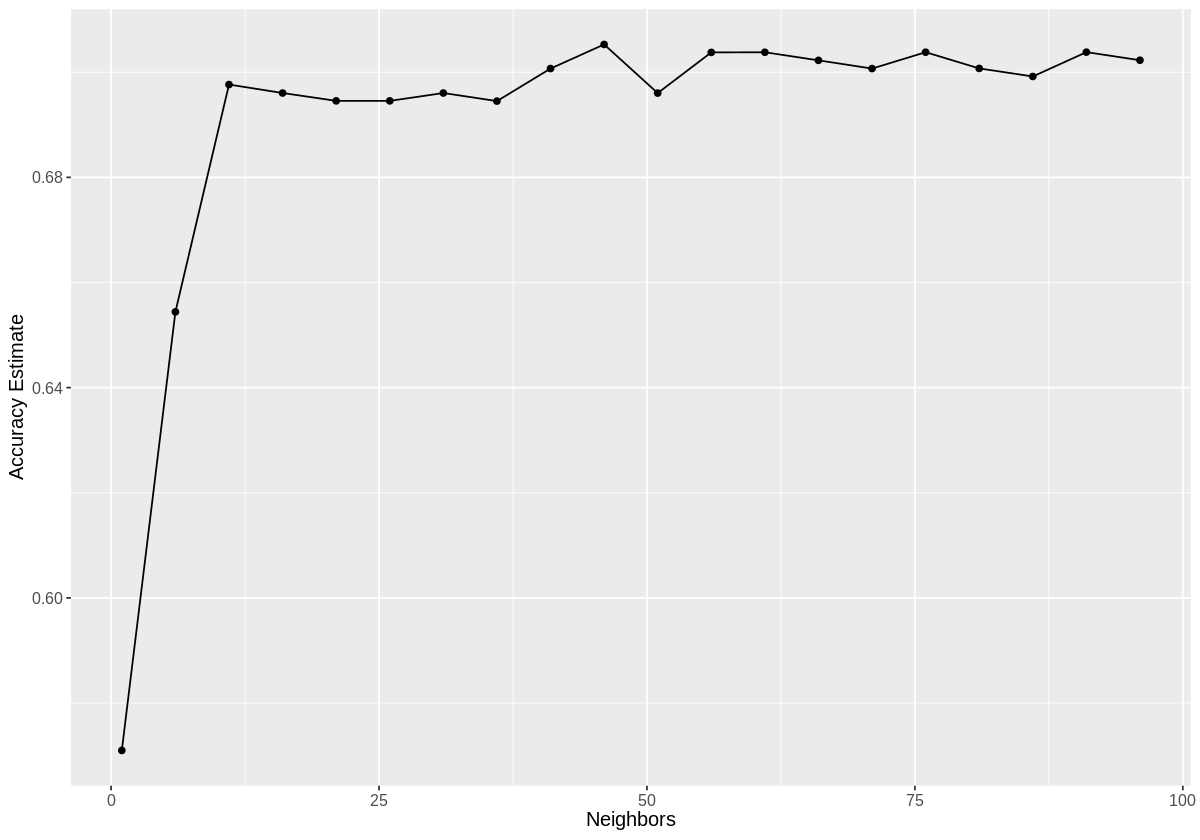

In [59]:
set.seed(3) #Remember to ensure the seed is the same

#Recipe
heart_disease_recipe <- recipe(is_disease_present ~ thalach + age, data = heart_disease_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

#KNN Spec
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#5 Cross-Validation
heart_disease_vfold <- vfold_cv(heart_disease_training, v = 5, strata = is_disease_present)

#Neighbours tested with increment of 10
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

#Workflow
knn_results <- workflow() |>
    add_recipe(heart_disease_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
    collect_metrics()


accuracies <- knn_results |>
     filter(.metric == "accuracy")

#Line Plot that measures the relation between #neighbours and accuracy of the predictor model
accuracy_vs_k_lots <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k_lots

#Returns the most optimal number for the neighbor
optimal_neighbor_number <- accuracies |>
    group_by(neighbors) |>
    arrange(by = desc(mean)) |>
    head(1) |>
    pull(neighbors)

optimal_neighbor_number

#Applying our best optimized predicting model onto our heart disease testing data
optimal_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_neighbor_number) |>
  set_engine("kknn") |>
  set_mode("classification")

optimal_knn_fit <- workflow() |>
  add_recipe(heart_disease_recipe) |>
  add_model(optimal_knn_spec) |>
  fit(data = heart_disease_training)

heart_disease_test_predictions <- predict(optimal_knn_fit, heart_disease_testing) |>
  bind_cols(heart_disease_testing)

heart_disease_test_predictions |>
  metrics(truth = is_disease_present, estimate = .pred_class) |>
  filter(.metric == "accuracy")

heart_disease_test_predictions

**Expected Outcomes and Significance**

**Expected finding**: With the increasing age, maximum heart rate, and resting blood pressure at admission, the likelihood of having heart disease is going to increase too.

**The impact of the finding**: Helping people to predict heart diseases better, or avoid getting heart diseases by gaining a better understanding of the associated risk factors.

**The future question**: We only examined the relationship between heart disease between 3 variables, but there are a total of 14 variables in the original dataset. There are more variables to be studied based on their relationships with heart disease.


**Reference**

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

V. Ramalingam, V., Dandapath, A., & Karthik Raja, M. (2018). Heart disease prediction using Machine Learning Techniques : A survey. *International Journal of Engineering & Technology*, 7(2.8), 684. https://doi.org/10.14419/ijet.v7i2.8.10557 